# Modelling and forecasting a potential chikungunya outbreak in France, 2025
**Author:** Sandeep Tegar<sup>1, 2</sup> and Dominic P. Brass<sup>1</sup> 

**Contact:** santeg@ceh.ac.uk  
**Date:** 2025-03-17   
**Affiliation:**
1. UK Centre for Ecology & Hydrology, Benson Lane, Wallingford, Oxfordshire, UK
2. School of Mathematics and Statistics, College of Science and Engineering, University of Glasgow, Glasgow, UK   


## Overview  
This notebook contains the code used obtain the Aedes albopictu population dynamics in Bernis. It performs model simulation using function `chikungunya()`. Finally, obtain the *Ae. albopictus* and its oviposition activity.  

## Requirements  
- Julia 1.10.0+  
- Required libraries: `Plots`, `DelayDiffEq`, `Dierckx`, `CSV`, `Interpolations`, `QuadGK`, `Statistics`, `Dates`, `DataFrames`, `RecurssiveArrayTools`, `TimeSeries` 
- Data files: `AMgam.csv`, `Car_Tol_1.csv`, `Fin_LSurv.csv`, `LDgam.csv`, `WL_re.csv`
- Function files: AlbopictusFun.jl
## Extra requirement
ERA5 climate data file "43.77_4.29.csv" (format: latitude_longitude.csv) coulmns: time, logitude, latitude, t2m, tp, evaow, where 't2m', 'tp', and 'evaow' stand for  "2m_temperature", "total_precipitation", and "evaporation_from_open_water_surfaces_excluding_oceans", respectively. Source: https://cds.climate.copernicus.eu/datasets/reanalysis-era5-land?tab=overview

## Usage  
Save all the required files in the working directory and simply run the cells in order to reproduce the results.  

In [20]:
# load the required packages 
using Plots, DelayDiffEq, Dierckx, CSV, Interpolations, QuadGK, Statistics, Dates, DataFrames, RecursiveArrayTools, TimeSeries

In [21]:
# call the dengue() frunction from AlbopictusFun file
include("AlbopictusFun1.jl")

chikungunya (generic function with 1 method)

In [22]:

# Simulate model for seeding date with the lowest RMSE
start_date_str = "18.11.2021"
seed_date_str = string(Dates.format(Date(2025, 06, 11), "dd.mm.yyyy"))
#seed_date_str = "29.07.2024"
sol, tauE, gt, q_store, egg_total_inst, tauL, tauP = chikungunya(43.77, 4.29, start_date_str, "30.12.2025", seed_date_str);

In [23]:
# Create the time array from the simulation output
time = sol.t
out = hcat(sol.u...)

206×1504 Matrix{Float64}:
    1.0           1.25883       1.39103    …     1.78622         1.70023
  150.0         148.507       147.03          6639.49         6573.42
    1.0           0.541899      0.290842         4.47841e-10     2.62747e-10
  100.0          79.2685       59.8256           0.565879        0.485005
    5.20589       5.20562       5.26246          4.63403         4.8149
    0.0411906     0.0411988     0.0394058  …     0.071283        0.0595952
   12.3554       12.35         12.3373          12.4107         12.4107
    0.0547221     0.0547586     0.052248         0.121003        0.115028
   17.2502       17.2502       17.2502          17.1085         17.1085
    0.0407573     0.0407573     0.0407573        0.0431481       0.0431481
    ⋮                                      ⋱                  
    0.818282      0.818297      0.815266         0.81279         0.804721
    0.818282      0.818297      0.815266         0.81279         0.804721
    0.818282      0.818297   

In [24]:
# numberings
nWing = 64
numb_E_1   = 1 
numb_E_D   = 2
numb_E_Q   = 3
numb_L_1   = 4
numb_t_E   = 5
numb_P_E   = 6
numb_t_L   = 7
numb_P_L   = 8
numb_t_P   = 9
numb_P_P   = 10
numb_A_1   = 11
numb_A_2       = nWing + 10
numb_I_1       = nWing + 11
numb_I_2       = 2* nWing + 10
numb_EIP       = 2 * nWing + 11
numb_P_EIP_1   = 2 * nWing + 12
numb_P_EIP_2   = 3 * nWing + 11
numb_H_S       = 3 * nWing + 12
numb_H_I       = 3 * nWing + 13
numb_H_R       = 3 * nWing + 14;

In [25]:
# total adults
adults = out[numb_A_1:numb_A_2, :]
sumA = sum(adults, dims=1)[1, :]

1504-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.9671170445320378
 0.9523379659506604
 0.9389235831999763
 0.9255976210432159
 0.9105610027427182
 0.8923283270513013
 0.8758413880032379
 0.8598544077875946
 0.8360588635692778

In [26]:
# oviposition activity
# total eggs
adults_AI = out[numb_A_1:numb_A_2, :]

tosum_E = (repeat(q_store, 1).*adults_AI)./transpose(gt)
eggs_in = sum(tosum_E, dims=1)[1, :]

eggs_daily_sp = Spline1D(time, eggs_in)
tauE_daily_sp = Spline1D(time, tauE)

sampling_period = 7

ovi_obs = repeat([0.0], length(time))
for i = 21:length(time)
    if tauE_daily_sp(i) < sampling_period
        ovi_obs[i] =   sum(eggs_daily_sp(1:i)) - sum(eggs_daily_sp(1:i - tauE_daily_sp(i)))
    else
        ovi_obs[i] =   sum(eggs_daily_sp(1:i)) - sum(eggs_daily_sp(1:Int(i - sampling_period)))
    end
end

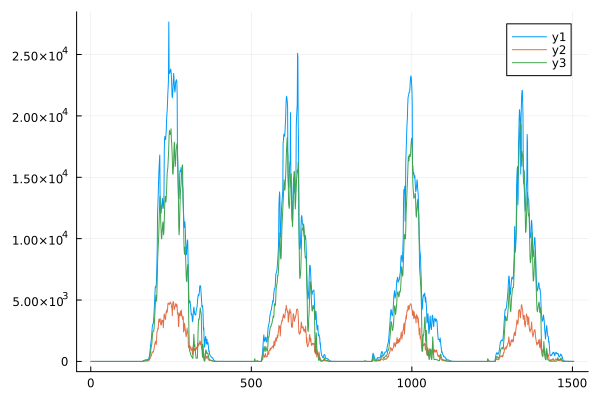

In [27]:
plot(ovi_obs)
plot!(eggs_in)
plot!(egg_total_inst)

In [28]:
# writing output time series
start_date = Date(start_date_str, "dd.mm.yyyy")
dates =  start_date .+ Day.(Int.(time))
egg_adult_data = hcat(sumA, egg_total_inst, eggs_in, ovi_obs)
ts = TimeArray(dates, egg_adult_data, ["total_adults", "egg_total_inst", "egg_daily", "egg_sampled"])

1504×4 TimeArray{Float64, 2, Date, Matrix{Float64}} 2021-11-18 to 2025-12-30
┌────────────┬──────────────┬────────────────┬───────────┬─────────────┐
│            │ total_adults │ egg_total_inst │ egg_daily │ egg_sampled │
├────────────┼──────────────┼────────────────┼───────────┼─────────────┤
│ 2021-11-18 │          0.0 │            2.0 │       0.0 │         0.0 │
│ 2021-11-19 │          0.0 │        1.80073 │       0.0 │         0.0 │
│ 2021-11-20 │          0.0 │        1.68187 │       0.0 │         0.0 │
│ 2021-11-21 │          0.0 │        1.51875 │       0.0 │         0.0 │
│ 2021-11-22 │          0.0 │        1.53051 │       0.0 │         0.0 │
│ 2021-11-23 │          0.0 │        1.53036 │       0.0 │         0.0 │
│ 2021-11-24 │          0.0 │        1.54899 │       0.0 │         0.0 │
│ 2021-11-25 │          0.0 │        1.55442 │       0.0 │         0.0 │
│     ⋮      │      ⋮       │       ⋮        │     ⋮     │      ⋮      │
│ 2025-12-24 │     0.938924 │        2.31625 │ 

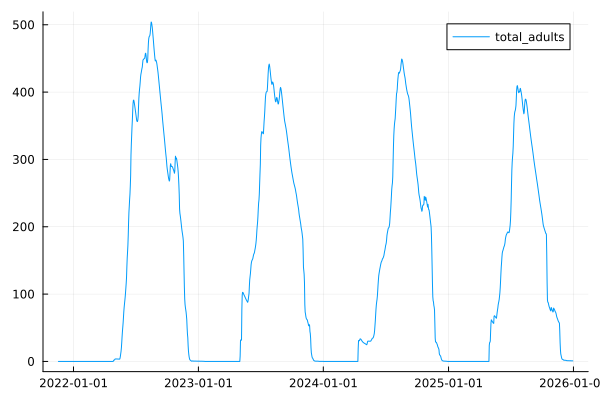

In [29]:
plot(ts["total_adults"])

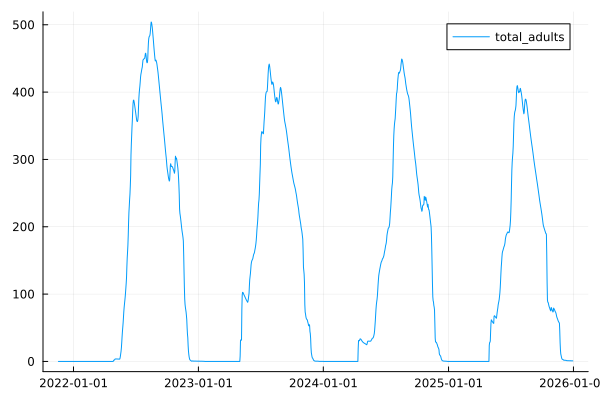

In [30]:
plot(ts["total_adults"])

In [31]:
# uncommnet to save output to csv
df = DataFrame(ts)
CSV.write("egg_adult_2015.csv", df)

"egg_adult_2015.csv"

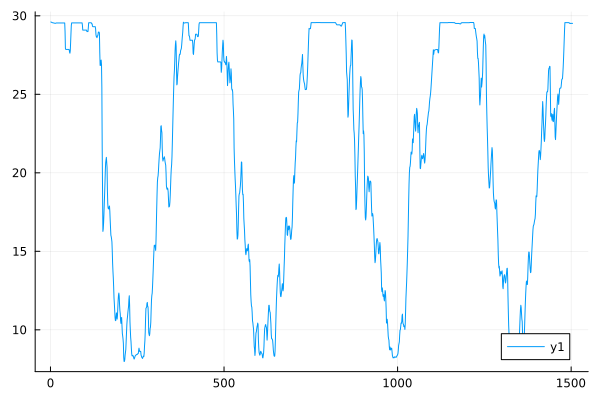

In [32]:
# Plot oviposition activity
plot(tauL.+tauP)

In [33]:
# writing output time series for Larval to Adult development time
start_date = Date(start_date_str, "dd.mm.yyyy")
dates =  start_date .+ Day.(Int.(time))
tauLP = tauL .+ tauP
dt_data = hcat(tauL, tauP, tauLP)
ts = TimeArray(dates, dt_data, ["dt_L", "dt_P", "dt_LP"])

1504×3 TimeArray{Float64, 2, Date, Matrix{Float64}} 2021-11-18 to 2025-12-30
┌────────────┬─────────┬─────────┬─────────┐
│            │ dt_L    │ dt_P    │ dt_LP   │
├────────────┼─────────┼─────────┼─────────┤
│ 2021-11-18 │ 12.3554 │ 17.2502 │ 29.6056 │
│ 2021-11-19 │   12.35 │ 17.2502 │ 29.6002 │
│ 2021-11-20 │ 12.3373 │ 17.2502 │ 29.5876 │
│ 2021-11-21 │ 12.3229 │ 17.2502 │ 29.5732 │
│ 2021-11-22 │ 12.3148 │ 17.2502 │  29.565 │
│ 2021-11-23 │ 12.3097 │ 17.2502 │ 29.5599 │
│ 2021-11-24 │ 12.3046 │ 17.2502 │ 29.5548 │
│ 2021-11-25 │ 12.2995 │ 17.2502 │ 29.5497 │
│     ⋮      │    ⋮    │    ⋮    │    ⋮    │
│ 2025-12-24 │ 12.3986 │ 17.1085 │  29.507 │
│ 2025-12-25 │ 12.4106 │ 17.1085 │  29.519 │
│ 2025-12-26 │ 12.4107 │ 17.1085 │ 29.5192 │
│ 2025-12-27 │ 12.4107 │ 17.1085 │ 29.5192 │
│ 2025-12-28 │ 12.4107 │ 17.1085 │ 29.5192 │
│ 2025-12-29 │ 12.4107 │ 17.1085 │ 29.5192 │
│ 2025-12-30 │ 12.4107 │ 17.1085 │ 29.5192 │
└────────────┴─────────┴─────────┴─────────┘
                       

In [34]:
# uncomment to save output to csv
#df = DataFrame(ts)
#CSV.write("fano_simulation/fano_sim_A/dt_A.csv", df)